In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa # audio processing
from IPython.display import Audio # playing audio
from matplotlib import pyplot as plt # plots
import librosa.display

!pip install noisereduce
import noisereduce as nr

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns


import os
#for dirname, _, filenames in os.walk('/kaggle/input/speech-emotion-recognition-en/Crema'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download dmitrybabko/speech-emotion-recognition-en

100% 985M/987M [00:06<00:00, 176MB/s]
100% 987M/987M [00:06<00:00, 152MB/s]


In [ ]:
!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

# Load Dataset

In [ ]:
data = [] # the audio signal
label = [] # the sentiment (for classification)
meta = [] # metadata (actor_sentence_sentiment_pitch)
sampling_rate = 18000 # all of them should have the same sampling rate

In [ ]:
def play_plot(index):
    print(meta[index])
    Audio(data=data[index], rate=sampling_rate)
    #fig, ax = plt.subplots(nrows=3, sharex=True)
    #librosa.display.waveshow(data[index], sr=sampling_rate, ax=ax[0])

In [ ]:
def adjust_length(time_series_list, length):
    n = len(time_series_list)
    for i in range(n):
        audio_length = len(time_series_list[i])
        if audio_length < length:
            time_series_list[i] = np.append(time_series_list[i], [0 for i in range(length-audio_length)])
        else:
            time_series_list[i] = np.array(time_series_list[i][:length])

In [ ]:
def check_for_nan(l):
    for x in l:
        if str(x) == 'nan':
            return True
    return False

In [ ]:
emotions_dict = dict()
emotions_dict['SAD'] = 0
emotions_dict['ANG'] = 1
emotions_dict['DIS'] = 2
emotions_dict['FEA'] = 3
emotions_dict['HAP'] = 4
emotions_dict['NEU'] = 5

In [ ]:
'''Load to lists.. takes too long, run it just once''' 
length_sum = 0
list_a = []
list_b = []
for dirname, _, filenames in os.walk('Crema'):
    for filename in filenames:
        meta.append(filename[:-4])
        full_filename = os.path.join(dirname, filename)
        sentiment = filename.split('_')[2]
        label.append(emotions_dict[sentiment])
        signal, sr = librosa.load(full_filename, sr = sampling_rate)
        reduced_noise = nr.reduce_noise(y=signal, sr=sampling_rate)
        if not check_for_nan(reduced_noise):
            signal = reduced_noise
        data.append(signal)
        length_sum += len(signal)
        if (len(data)%100 == 0):
            print(len(data), " audio loaded")
n = len(data)
adjust_length(data, 3*sampling_rate)
data = np.array(data)

100  audio loaded
200  audio loaded
300  audio loaded
400  audio loaded
500  audio loaded
600  audio loaded
700  audio loaded
800  audio loaded
900  audio loaded
1000  audio loaded
1100  audio loaded
1200  audio loaded
1300  audio loaded
1400  audio loaded
1500  audio loaded
1600  audio loaded
1700  audio loaded
1800  audio loaded
1900  audio loaded
2000  audio loaded
2100  audio loaded
2200  audio loaded
2300  audio loaded
2400  audio loaded
2500  audio loaded
2600  audio loaded
2700  audio loaded
2800  audio loaded
2900  audio loaded
3000  audio loaded
3100  audio loaded
3200  audio loaded
3300  audio loaded
3400  audio loaded
3500  audio loaded


/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:306: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


3600  audio loaded
3700  audio loaded
3800  audio loaded
3900  audio loaded
4000  audio loaded
4100  audio loaded
4200  audio loaded
4300  audio loaded
4400  audio loaded
4500  audio loaded
4600  audio loaded
4700  audio loaded
4800  audio loaded
4900  audio loaded
5000  audio loaded
5100  audio loaded
5200  audio loaded
5300  audio loaded
5400  audio loaded
5500  audio loaded
5600  audio loaded
5700  audio loaded
5800  audio loaded
5900  audio loaded
6000  audio loaded
6100  audio loaded
6200  audio loaded
6300  audio loaded
6400  audio loaded
6500  audio loaded
6600  audio loaded
6700  audio loaded
6800  audio loaded
6900  audio loaded
7000  audio loaded
7100  audio loaded
7200  audio loaded
7300  audio loaded
7400  audio loaded


## Display metadata, play audio and plot waveform

In [ ]:
index = 5

In [ ]:
Audio(data=data[index], rate=sampling_rate)

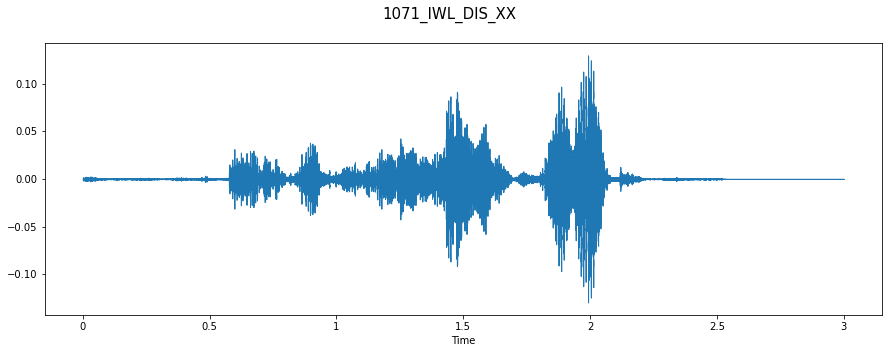

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.suptitle(meta[index], fontsize=15)
librosa.display.waveshow(data[index], sr=sampling_rate)

## Feature Extraction

In [ ]:
def feature_extraction_1D(data):

    # Zero Crossing rate
    features = librosa.feature.zero_crossing_rate(y=data)

    # Energy
    features = np.append(features, librosa.feature.rms(y=data), axis=1)

    # Mel-frequency cepstral coefficient
    l = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0).reshape(1, 106)
    features = np.append(features, l, axis=1)
    
    # Spectral Centroid
    features = np.append(features, librosa.feature.spectral_centroid(y=data, sr=sampling_rate), axis=1)
    
    # Spectral Bandwidth
    features = np.append(features, librosa.feature.spectral_bandwidth(y=data, sr=sampling_rate), axis=1)
    
    # Spectral Flatness
    features = np.append(features, librosa.feature.spectral_flatness(y=data), axis=1)
    
    # Spectral Rolloff maximum frequencies
    features = np.append(features, librosa.feature.spectral_rolloff(y=data, sr=sampling_rate), axis=1)
    
    # Spectral Rolloff minimum frequencies
    features = np.append(features, librosa.feature.spectral_rolloff(y=data, sr=sampling_rate, roll_percent=0.01), axis=1)
    
    return np.array(features)

In [ ]:
data_features_extracted_1D = []
for i in range(n):
    data_features_extracted_1D.append(np.squeeze(np.append(feature_extraction_1D(data[i]), label[i])))
    if (len(data_features_extracted_1D)%100 == 0):
            print(len(data_features_extracted_1D), " entry processed")
data_features_extracted_1D = np.array(data_features_extracted_1D)
print(data_features_extracted_1D.shape)

100  entry processed
200  entry processed
300  entry processed
400  entry processed
500  entry processed
600  entry processed
700  entry processed
800  entry processed
900  entry processed
1000  entry processed
1100  entry processed
1200  entry processed
1300  entry processed
1400  entry processed
1500  entry processed
1600  entry processed
1700  entry processed
1800  entry processed
1900  entry processed
2000  entry processed
2100  entry processed
2200  entry processed
2300  entry processed
2400  entry processed
2500  entry processed
2600  entry processed
2700  entry processed
2800  entry processed
2900  entry processed
3000  entry processed
3100  entry processed
3200  entry processed
3300  entry processed
3400  entry processed
3500  entry processed
3600  entry processed
3700  entry processed
3800  entry processed
3900  entry processed
4000  entry processed
4100  entry processed
4200  entry processed
4300  entry processed
4400  entry processed
4500  entry processed
4600  entry process

# Split Data

In [ ]:
def split_1D(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y)
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = split_1D(data_features_extracted_1D[:, :-1], label)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.tensor(y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]
    
train_ds = AudioDataset(x_train, y_train)
test_ds = AudioDataset(x_test, y_test)
train_dl = DataLoader(train_ds, batch_size = 1000,shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 100,shuffle = False)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 =self.audio() 
        self.layer2=self.linear()
        
    def audio(self):
        layer=nn.Sequential(  
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=3),
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=128,out_channels=256,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=256,out_channels=256,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=256,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2),
            nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,stride=2)
        )
        return layer
    def linear(self):
        layer=nn.Sequential(
                nn.Flatten(),
                nn.Linear(4096,1024),nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024,6)
                )
        return layer
        
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x



# CNN Model

In [ ]:
def train_one_epoch(model, optimizer, train_dl):
    device = "cuda" if torch.cuda.is_available else "cpu"
    train_loss = 0
    for X, y in train_dl:
        model.train()
        X = X.unsqueeze(1).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        torch.cuda.empty_cache()
    train_loss = train_loss / len(train_dl.dataset)
    return train_loss


def test(model, test_dl):
    device = "cuda" if torch.cuda.is_available else "cpu"
    test_loss = 0
    accuracy = 0
    for X, y in test_dl:
        X = X.unsqueeze(1).to(device)
        y = y.to(device)
        model.eval()
        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y)

        test_loss += loss.item() * X.size(0)
        accuracy += sum(y_pred.argmax(dim=1) == y)
        torch.cuda.empty_cache()
    # calculate accuracy and loss
    test_loss = test_loss / len(test_dl.dataset)
    accuracy = accuracy / len(test_dl.dataset)
    return test_loss, accuracy.item()


def train_loop(model, optimizer, train_dl, test_dl, epoch):
    for i in range(epoch):
        train_loss = train_one_epoch(model, optimizer, train_dl)
        test_loss, test_acc = test(model, test_dl)
        if i%5 == 0:
          print(
              f"""train loss:{round(train_loss, 3)}, test loss: {round(test_loss, 3)}, test acc: {round(test_acc, 3)}""")

In [1]:
model = CNN().cuda()
optimizer=torch.optim.Adam(model.parameters(),lr=5e-4,weight_decay=5e-4) 
train_loop(model,optimizer,train_dl,test_dl,10)

train loss:5.916, test loss: 1.684, test acc: 0.310
train loss:1.527, test loss: 1.552, test acc: 0.323
train loss:0.929, test loss: 0.827, test acc: 0.482
train loss:1.622, test loss: 1.638, test acc: 0.278
train loss:0.892, test loss: 0.845, test acc: 0.404
train loss:0.853, test loss: 0.820, test acc: 0.420
train loss:0.820, test loss: 0.817, test acc: 0.432
train loss:0.737, test loss: 0.782, test acc: 0.712
train loss:0.608, test loss: 0.450, test acc: 0.802
train loss:0.426, test loss: 0.430, test acc: 0.825


In [2]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=5e-4) 
train_loop(model,optimizer,train_dl,test_dl,5)

train loss:0.468, test loss: 0.433, test acc: 0.843
train loss:0.457, test loss: 0.428, test acc: 0.827
train loss:0.403, test loss: 0.411, test acc: 0.871
train loss:0.309, test loss: 0.334, test acc: 0.879
train loss:0.218, test loss: 0.323, test acc: 0.881



## RESNET

In [ ]:
class ResNetblock(nn.Module):
    def __init__(self,input_channel,out_channel,stride=1, convx=False):
        super(ResNetblock,self).__init__()
        self.C1 = nn.Conv1d(input_channel,out_channel,kernel_size=3,padding=1,stride=stride)
        self.B1 = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.C2 = nn.Conv1d(out_channel,out_channel,kernel_size=3,padding=1)
        self.B2 = nn.BatchNorm1d(out_channel)

        if convx:
            self.CX = nn.Conv1d(input_channel,out_channel,kernel_size=1,stride=stride)
        else:
            self.CX=None

    def forward(self,X):
        Y = self.relu(self.B1(self.C1(X)))
        Y = self.B2(self.C2(Y))
        if self.CX:
            X = self.CX(X)
        Y+=X
        return F.relu(Y)

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.b1 = self.head_(1)
        self.b2 = nn.Sequential(*self.resnetblock_(64, 64, 2, first=True))
        self.b3 = nn.Sequential(*self.resnetblock_(64, 128, 2))
        self.b4 = nn.Sequential(*self.resnetblock_(128, 256, 2))
        self.b5 = nn.Sequential(*self.resnetblock_(256, 256, 2))
        self.b6 = nn.Sequential(*self.resnetblock_(256, 512, 2))
        self.connect = nn.Sequential(nn.Flatten(),
                                     nn.Linear(4608,512),nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(512,6)
                                    )
                        
    def forward(self,X):
        X=self.b1(X)
        X=self.b2(X)
        X=self.b3(X)
        X=self.b4(X)
        X=self.b5(X)
        X=self.b6(X)
        X=self.connect(X)
        return X
        
        
        
        
    def head_(self,input_channel):
        head = nn.Sequential(nn.Conv1d(input_channel,64,kernel_size=7,stride=3,padding=3),
                               nn.BatchNorm1d(64),
                               nn.MaxPool1d(kernel_size=3,padding=1,stride=2))
        return head

    def resnetblock_(self,input_channel,output_channel,num_res,first = False):
        block=[]
        for i in range(num_res):
            if i==0 and not first:
                block.append(ResNetblock(input_channel,output_channel,stride=2,convx=True))
            else:
                block.append(ResNetblock(output_channel,output_channel))
        return block




In [3]:
model = ResNetblock().cuda()
optimizer=torch.optim.Adam(model.parameters(),lr=5e-4,weight_decay=5e-4) 
train_loop(model,optimizer,train_dl,test_dl,6)

train loss:2.711, test loss: 1.678, test acc: 0.318
train loss:1.432, test loss: 1.216, test acc: 0.344
train loss:0.929, test loss: 0.827, test acc: 0.682
train loss:0.813, test loss: 0.799, test acc: 0.697
train loss:0.706, test loss: 0.693, test acc: 0.715
train loss:0.517, test loss: 0.482, test acc: 0.839


In [4]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=5e-4) 
train_loop(model,optimizer,train_dl,test_dl,3)

train loss:0.441, test loss: 0.423, test acc: 0.851
train loss:0.311, test loss: 0.302, test acc: 0.896
train loss:0.284, test loss: 0.297, test acc: 0.910


In [ ]:
class GRU1(nn.Module):
    def __init__(self):
        super(GRU1, self).__init__()
        # padding index turns off gradient for unknown tokens
        #self.word_emb = nn.Embedding(dict_length, embedding_size)
        
        # RNN doesn't care about length of sequence
        # RNN does care about the size of the word embedding
        # hidden size dictates dimension of output of RNN
        self.gru = nn.GRU(input_size=1, hidden_size=50, num_layers = 2, bidirectional=True)
        #self.gru = nn.GRU(input_size=848, hidden_size=50)
        self.linear1 = nn.Linear(100, 128)
        self.nolin = nn.LeakyReLU()
        self.linear2 = nn.Linear(128, 6)
        
        # PyTorch RNN outputs a sequence of same length as input
        # For many to one, we can either use the final hidden state OR
        # slap a linear layer on the output, taking in all the hidden states
        
    def forward(self, x):
        #x = self.word_emb(x)
        
        # RNN layer outputs a tuple, the output and the final hidden state
        # taking the final hidden state as output
        output, ht = self.gru(x.unsqueeze(2))

        re = self.linear1(output[:,-1, :])
        re = self.nolin(re)
        re = self.linear2(re)
        return re

        #return torch.squeeze(x)


In [ ]:
GRU_model = GRU1()
#GRU_model(x).size()
GRU_model(x).size()

torch.Size([1000, 6])

In [9]:
GRU_model = GRU1().cuda()
optimizer=torch.optim.Adam(GRU_model.parameters(),lr=0.005) 
train_loop(GRU_model,optimizer,train_dl,test_dl,5)

train loss:1.791, test loss: 1.787, test acc: 0.179
train loss:1.454, test loss: 1.248, test acc: 0.305
train loss:1.158, test loss: 1.127, test acc: 0.302
train loss:1.032, test loss: 1.035, test acc: 0.358
train loss:0.933, test loss: 0.938, test acc: 0.406


In [ ]:
class LSTM1(nn.Module):
    def __init__(self):
        super(LSTM1, self).__init__()
        # padding index turns off gradient for unknown tokens
        #self.word_emb = nn.Embedding(dict_length, embedding_size)
        
        # RNN doesn't care about length of sequence
        # RNN does care about the size of the word embedding
        # hidden size dictates dimension of output of RNN
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers = 2, bidirectional=True)
        #self.gru = nn.GRU(input_size=848, hidden_size=50)
        self.linear1 = nn.Linear(100, 128)
        self.nolin = nn.LeakyReLU()
        self.linear2 = nn.Linear(128, 6)
        
        # PyTorch RNN outputs a sequence of same length as input
        # For many to one, we can either use the final hidden state OR
        # slap a linear layer on the output, taking in all the hidden states
        
    def forward(self, x):
        #x = self.word_emb(x)
        
        # RNN layer outputs a tuple, the output and the final hidden state
        # taking the final hidden state as output
        output, (ht,ct) = self.lstm(x.unsqueeze(2))

        re = self.linear1(output[:, -1, :])
        re = self.nolin(re)
        re = self.linear2(re)
        return re

        #return torch.squeeze(x)

In [8]:
lstm_model = LSTM1().cuda()
optimizer=torch.optim.Adam(lstm_model.parameters(),lr=0.005) 
train_loop(lstm_model,optimizer,train_dl,test_dl,30)

train loss:1.792, test loss: 1.784, test acc: 0.179
train loss:1.436, test loss: 1.134, test acc: 0.393
train loss:1.037, test loss: 1.018, test acc: 0.472
train loss:0.908, test loss: 0.879, test acc: 0.595
train loss:0.708, test loss: 0.699, test acc: 0.534


In [ ]:
class attention1(nn.Module):
    def __init__(self):
        super(attention1, self).__init__()
        # padding index turns off gradient for unknown tokens
        #self.word_emb = nn.Embedding(dict_length, embedding_size)
        
        # RNN doesn't care about length of sequence
        # RNN does care about the size of the word embedding
        # hidden size dictates dimension of output of RNN
        self.attn = nn.MultiheadAttention(1,1)
        self.linear1 = nn.Linear(848, 256)
        self.nolin = nn.LeakyReLU()
        self.linear2 = nn.Linear(256, 6)
        
        # PyTorch RNN outputs a sequence of same length as input
        # For many to one, we can either use the final hidden state OR
        # slap a linear layer on the output, taking in all the hidden states
        
    def forward(self, x):
        #x = self.word_emb(x)
        
        # RNN layer outputs a tuple, the output and the final hidden state
        # taking the final hidden state as output
        x = x.unsqueeze(2)
        attn_output, attn_output_weights = self.attn(x, x, x)
        re = self.linear1(attn_output.squeeze())
        re = self.nolin(re)
        re = self.linear2(re)
        
        return re

In [10]:
attention_model = attention1().cuda()
optimizer=torch.optim.Adam(attention_model.parameters(),lr=0.005) 
train_loop(attention_model,optimizer,train_dl,test_dl,5)

train loss:92.347, test loss: 53.356, test acc: 0.170
train loss:2.364, test loss: 2.686, test acc: 0.179
train loss:1.167, test loss: 1.223, test acc: 0.314
train loss:0.701, test loss: 0.693, test acc: 0.493
train loss:0.609, test loss: 0.597, test acc: 0.632
